# Pytorch Lightning Tutorial

This model will be a binary classification model to either say that the data contains background (B) only or background + signal (B + S).

## Advatages of Pytorch Lightning

- Easy to install using pip.
- Framework’s code tends to be simple, clean, and easy to reproduce, because engineering code is abstracted away.
- It supports 16-bit precision. This helps in speeding up model training.
- It can run ***distributed training***. It supports training on multiple machines at the same time. PL handles the computing architecture on its own.
- It supports model checkpointing. Checkpointing is a way to save the current state of your experiment so that you can pick up from where you left off. This helps to recover previous states in case something happens i.e., power outages.
- It integrates easily with other popular machine learning tools (e.g., Google’s Tensorboard).
- Compared to PyTorch, it has a minimum running speed overhead of about 300ms which makes it pretty fast.
- Its models are hardware agnostic. If it runs on CPU, it will run on any GPU or TPU machines.
- More pythonic style with class based structure.
- Very active community.

## Import Modules

In [144]:
# BUILD ON TOP OF TORCH
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch.distributions import Normal, Uniform
from torch.functional import F
# LIGHTNING 
import pytorch_lightning as pl
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import TQDMProgressBar
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping -> really nioce why to implement early stopping

# PLOTTING
import matplotlib.pyplot as plt
import numpy as np

## Data

### Define the Dataset and structure 

In [145]:
class SignalDataset(Dataset):
    def __init__(self, size) -> None:
        super().__init__()

        # mass of hypothetical particle in GeV
        self.mass_hyp_particle = 0.3 # GeV

        # dataset
        self.dataset = {}

        # size of the dataset
        self.size = size

        # number of events
        self.num_events = 100000
        
        # range of the dataset
        xrange = torch.linspace(0, 1, 21)

        # distributions
        bkg = Uniform(low=0, 
                      high=1)
        signal = Normal(loc=self.mass_hyp_particle,
                        scale=0.001)

        for gen_idx in range(self.size):

            # half must be bkg only
            # other half is bgk + signal
            if gen_idx < int(self.size/2):
                x = bkg.rsample(sample_shape=(self.num_events,))
                Y = torch.tensor(data=[0.0])
            else:
                x = 0.1 * signal.rsample(sample_shape=(self.num_events,)) + \
                    0.9 * bkg.rsample(sample_shape=(self.num_events,))
                Y = torch.tensor(data=[1.0])

            hist, bins = torch.histogram(input=x,
                                         bins=xrange,
                                         density=True)
            # cbins = (bins[1:] + bins[:-1])/2
            X = hist
            
            # put everything into the dataset
            self.dataset[gen_idx] = [X, Y]

    # this is necessary
    def __len__(self):
        return self.size

    # this is necessary
    def __getitem__(self, index):
        return self.dataset[index]

### Generate the data and put into loader

In [146]:
# initialize dataset
train_dataset = SignalDataset(size=1000)
val_dataset = SignalDataset(size=100)
test_dataset = SignalDataset(size=100)
# initialize dataloader that allows very nice 
# applications, such as transforms and shuffling...
train_dataloader = DataLoader(dataset=train_dataset,
                        batch_size=16,
                        shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                        batch_size=16,
                        shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,
                        batch_size=16)

## Model

In [147]:
class ClassificationModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.train_loss_total = []
        self.val_loss_total = []
        self.total_acc = []

        self.performance = None

        self.model = nn.Sequential(
            nn.Linear(20, 20),
            nn.PReLU(),
            nn.Linear(20, 20),
            nn.PReLU(),
            nn.Linear(20, 20),
            nn.PReLU(),
            nn.Linear(20, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return Adam(self.parameters())

    def training_step(self, batch, batch_idx):
        x, y = batch
        train_loss = F.binary_cross_entropy(self.model(x), y)
        self.train_loss_total.append(train_loss.detach().numpy())
        return train_loss 
    
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        val_loss = F.binary_cross_entropy(self.model(x), y)
        self.val_loss_total.append(val_loss.detach().numpy())
        return val_loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = torch.round(self.model(x))
        accuracy = torch.sum(y == y_pred)/len(y_pred)
        self.total_acc.append(accuracy.detach().numpy())
        return accuracy


## Training

In [148]:
model = ClassificationModel()
trainer = Trainer(min_epochs=1,
                  max_epochs=10,
                  callbacks=[TQDMProgressBar(refresh_rate=10)]) # lots of methods that make training easy and trackable
trainer.fit(model=model,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 1.3 K 
-------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Losses

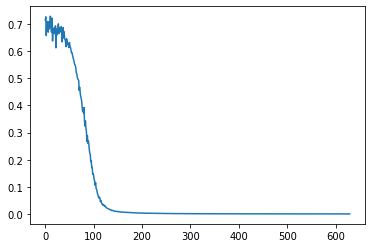

In [149]:
plt.plot(model.train_loss_total)


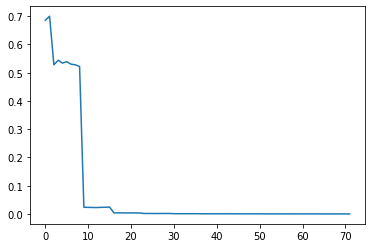

In [150]:
plt.plot(model.val_loss_total)

In [151]:
trainer.test(model=model,
             dataloaders=test_dataloader)

/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[{}]

In [152]:
np.mean(model.total_acc)

1.0

### Look at certain events

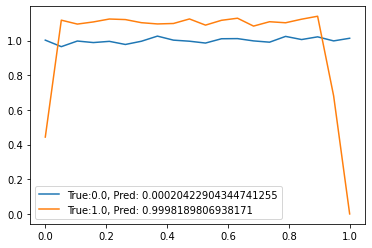

In [155]:
bkg_only_x, bkg_only_y = test_dataset[0]
mixed_x, mixed_y = test_dataset[51]

plt.plot(np.linspace(0, 1, 20), np.array(bkg_only_x), label=f"True:{bkg_only_y.detach().numpy()[0]}, Pred: {model(bkg_only_x).detach().numpy()[0]}")
plt.plot(np.linspace(0, 1, 20), np.array(mixed_x), label=f"True:{mixed_y.detach().numpy()[0]}, Pred: {model(mixed_x).detach().numpy()[0]}")
plt.legend()
